In [1]:
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import glob
from tqdm import tqdm

## Read in sunshine hours

### Read in NetCDF and convert to dataframes

In [3]:
path_to_netCDF_sunhours = "E:\ORD49239"
df_parts = []
for netcdf_file in tqdm(glob.glob(f"{path_to_netCDF_sunhours}\*")):
    ds_part = xr.open_dataset(netcdf_file, engine='netcdf4')
    df_parts.append(ds_part.to_dataframe())
    break # TODO: Remove after debugging

  0%|          | 0/192 [00:00<?, ?it/s]


### Handle NaNs

* Where do the NaNs come from: I assume they come from stations not recording values on a certain date. Since
we are interested in averages over countries as a whole, it should not pose an issue to drop them. This will also
reduce the number of rows.

In [21]:
test_df = df_parts[0].dropna().reset_index()
test_df.head()

,lon,lat,time,SDU
0,-65.0,-22.299999,2000-01-01,110.577332
1,-65.0,-22.250000,2000-01-01,114.464058
2,-65.0,-22.200001,2000-01-01,121.085159
3,-65.0,-22.150000,2000-01-01,120.345100
4,-65.0,-22.100000,2000-01-01,121.679955


### Reduce dataset size by excluding non-EU countries

We can do this by loading the world map, filtering out the EU countries
and then removing all coordinates outside the min-max square of the EU.

For this, the following shape file will be used to define coordinate bounds
between countries:

In [68]:
import geopandas as gpd

In [96]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
europe = world[world.continent == 'Europe']

#### Ignored countries (Blacklist)
In this section, we define countries to leave out of the processing by adding their country
codes in ISO_A3 to the list below:

In [163]:
ignored_countries = ['RUS']
europe = europe[~europe['iso_a3'].isin(ignored_countries)]

### Map coordinates to country

We use geopandas to merge the world borders with the dataset by long/lat

In [164]:
gdf = gpd.GeoDataFrame(test_df, geometry=gpd.points_from_xy(test_df.lon, test_df.lat))

Calculate median SDU (sunshine duration) per country in europe:

In [165]:
gdf_country = gpd.sjoin(gdf, europe, how='inner')
gdf_country.head()

,lon,lat,time,SDU,geometry,index_right,pop_est,continent,name,iso_a3,gdp_md_est
278892,-54.500000,2.35,2000-01-01,138.491837,POINT (-54.50000 2.35000),43,67059887.0,Europe,France,FRA,2715518
280560,-54.450001,2.30,2000-01-01,140.067657,POINT (-54.45000 2.30000),43,67059887.0,Europe,France,FRA,2715518
280561,-54.450001,2.35,2000-01-01,139.915192,POINT (-54.45000 2.35000),43,67059887.0,Europe,France,FRA,2715518
280562,-54.450001,2.40,2000-01-01,135.425186,POINT (-54.45000 2.40000),43,67059887.0,Europe,France,FRA,2715518
280607,-54.450001,4.65,2000-01-01,153.570526,POINT (-54.45000 4.65000),43,67059887.0,Europe,France,FRA,2715518


In [166]:
gdf_country_median = gdf_country.groupby('name').median().loc[:, ['SDU']]
gdf_country_median.head()

,SDU
name,
Albania,166.964035
Austria,68.798660
Belarus,33.689892
Belgium,58.523132
Bosnia and Herz.,87.071968


### Create a cloropleth plot for SDU

In [167]:
merged = europe.set_index('name').join(gdf_country_median)
merged.head()

,pop_est,continent,iso_a3,gdp_md_est,geometry,SDU
name,,,,,,
Norway,5347896.0,Europe,NOR,403336,"MULTIPOLYGON (((15.14282 79.67431, 15.52255 80...",8.169410
France,67059887.0,Europe,FRA,2715518,"MULTIPOLYGON (((-51.65780 4.15623, -52.24934 3...",87.718155
Sweden,10285453.0,Europe,SWE,530883,"POLYGON ((11.02737 58.85615, 11.46827 59.43239...",27.591003
Belarus,9466856.0,Europe,BLR,63080,"POLYGON ((28.17671 56.16913, 29.22951 55.91834...",33.689892
Ukraine,44385155.0,Europe,UKR,153781,"POLYGON ((32.15944 52.06125, 32.41206 52.28869...",42.825497


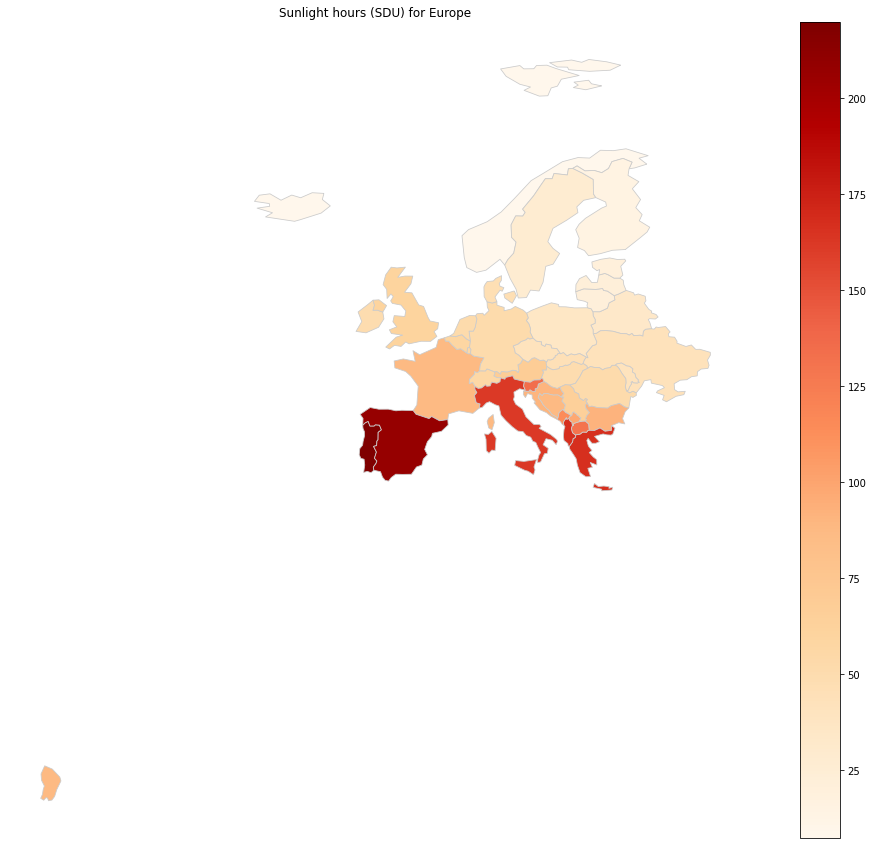

In [169]:
fig, ax = plt.subplots(1, figsize=(20, 15))
merged.plot(column='SDU', cmap='OrRd', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)
ax.axis('off')
plt.title("Sunlight hours (SDU) for Europe");